In [15]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library(ggpubr)
library(ggExtra)
library(ggridges)

In [9]:
meta_data<-read.csv('03_TEAseq_PenSenior/meta_data_GEO.csv')
meta_data<-meta_data[c('combined_sample_id','subject_id.ch1')]
colnames(meta_data)[1]<-'Sample'

# Violin Plot

In [4]:
df<-read.table('03_TEAseq_PenSenior/motif_score_all_cell.csv',sep=',',header=TRUE)

In [11]:
df_subset<-as.data.frame(df) %>% select (Sample,AIFI_L3,motif_GATA3_384)

In [12]:
selected_celltype<-c('Core naive CD4 T cell','Core naive CD8 T cell',
'CM CD8 T cell','GZMK+ CD27+ EM CD8 T cell')
df_subset<-df_subset %>% filter(AIFI_L3 %in% selected_celltype)

In [13]:
df_subset <- df_subset %>%
  left_join(meta_data) %>%
  mutate('Age Group' = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "Older",
    TRUE ~ 'Childern' 
  ))

Joining with `by = join_by(Sample)`


In [24]:
df_subset$AIFI_L3<-factor(df_subset$AIFI_L3,level=rev(c('Core naive CD4 T cell','Core naive CD8 T cell',
'CM CD8 T cell','GZMK+ CD27+ EM CD8 T cell')))

Picking joint bandwidth of 0.0129

Picking joint bandwidth of 0.0129



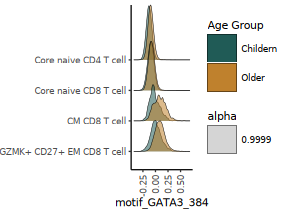

In [27]:
options(repr.plot.width = 60/25.4, repr.plot.height = 45/25.4)

P<-ggplot(df_subset) +
    geom_density_ridges(linewidth=0.1,
        aes(x = motif_GATA3_384,
            y = AIFI_L3,
            fill = `Age Group`,alpha=0.9999)) +
    ylab(NULL) +
theme_classic(base_size=6)+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
scale_fill_manual(values = c("Older" = '#bf812d', "Childern" = '#205B56'))#+theme(legend.position="none")
P
ggsave('FigureI.pdf',P,width = 50/25.4,height = 45/25.4)